In [25]:
import numpy as np
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel
from skopt.acquisition import gaussian_ei, gaussian_lcb, gaussian_pi
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [10]:
# Your experimental data
X_sample = np.array([[0.1], [0.3], [0.6], [0.8]])
Y_sample = np.array([-0.5, -0.2, 0.4, 0.1])

# Fit your own GP surrogate (same as skopt uses internally)
kernel = Matern(length_scale=1.0, nu=2.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    alpha=1e-6,
    n_restarts_optimizer=5,
    random_state=0
)
gp.fit(X_sample, Y_sample)

# Choose your acquisition function (same as skopt)
def acquisition(x, acq_func="EI"):
    x = np.array(x).reshape(1, -1)
    mu, sigma = gp.predict(x, return_std=True)
    y_max = np.max(Y_sample)

    if acq_func == "EI":
        return -gaussian_ei(x, gp, y_max)
    elif acq_func == "PI":
        return -gaussian_pi(x, gp, y_max)
    elif acq_func == "LCB":
        return -gaussian_lcb(x, gp)
    else:
        raise ValueError("Unsupported acquisition function.")

# Optimize acquisition function to get next point
def propose_next(acq_func="PI", bounds=[(0.0, 1.0)]):
    best_x = None
    best_val = np.inf
    for _ in range(10):  # multiple restarts
        x0 = np.random.uniform(bounds[0][0], bounds[0][1], size=(1,))
        res = minimize(
            lambda x: acquisition(x, acq_func=acq_func),
            x0,
            bounds=bounds,
            method="L-BFGS-B"
        )
        if res.fun < best_val:
            best_x = res.x
            best_val = res.fun
    return best_x

mu, std = gp.predict([[0.1]], return_std=True)
ei_val = gaussian_ei([[0.1]], gp, np.max(Y_sample))
print(f"At x = 0.1 → mu = {mu[0]:.4f}, std = {std[0]:.6f}, EI = {ei_val[0]:.6f}")

next_x = propose_next(acq_func="EI")
print(f"Next x to try: {next_x[0]:.4f}")

At x = 0.1 → mu = -0.5000, std = 0.000335, EI = 0.890000
Next x to try: 0.0937


c:\Users\mfvhi\Downloads\ML\ML\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


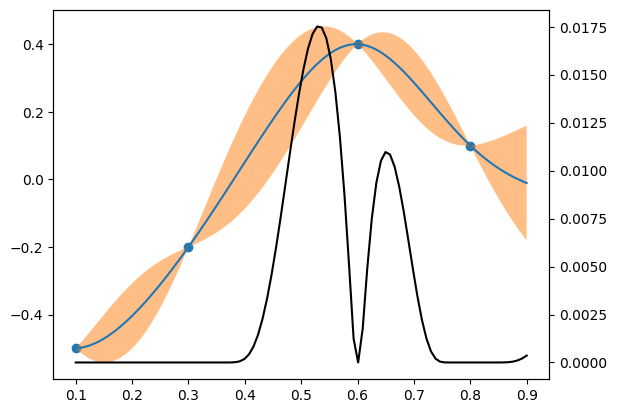

In [50]:
# Your experimental data
X_sample = np.array([[0.1], [0.3], [0.6], [0.8]])
Y_sample = np.array([-0.5, -0.2, 0.4, 0.1])

#X_sample = np.array([[0.1], [0.3], [0.6], [0.8], [0.3], [0.6]])
#Y_sample = np.array([-0.5, -0.2, 0.4, 0.1, -0.25, 0.6])


# Fit your own GP surrogate (same as skopt uses internally)
variance = 1e-6
kernel = Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=variance) # , noise_level_bounds=(0.05, 0.2)
gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True, # dont do in the future?
    #alpha=1,
    n_restarts_optimizer=5,
    random_state=0
)
gp.fit(X_sample, Y_sample)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_sample, Y_sample)

x_pred = np.linspace(0.1,0.9,100)
y_pred, y_std = gp.predict(x_pred.reshape(-1, 1), return_std=True)

ax.plot(x_pred, y_pred)

ax.fill_between(x_pred, y_pred - y_std, y_pred + y_std, alpha=0.5)

from scipy.stats import norm
def expected_improvement(X, model, y_opt, xi=0.01):
    mu, sigma = model.predict(X, return_std=True)
    mu = mu.reshape(-1, 1)
    sigma = sigma.reshape(-1, 1)
    with np.errstate(divide='warn'):
        Z = (mu - y_opt - xi) / sigma
        ei = (mu - y_opt - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma < 1e-8] = 0.0
    return ei.ravel()

ax2 = ax.twinx()

ei = expected_improvement(x_pred.reshape(-1, 1), gp, np.max(y_pred))
ax2.plot(x_pred, ei, c='k')